In [1]:
!pip install yfinance
!pip install pyts
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import yfinance as yf
import tensorflow as tf
import tensorflow_datasets as tfds
from pyts.image import GramianAngularField
from skimage.transform import resize

In [3]:
import math

import six
from einops.layers.tensorflow import Rearrange
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard

from tensorflow.keras import datasets

import logging
import numpy as np

from fastprogress import master_bar, progress_bar

In [4]:
# Code to download the stock data
stock_symbol = 'KOTAKBANK.NS'

# Fetch historical data for the company
stock_data = yf.download(stock_symbol, period="5y")
df = pd.DataFrame(stock_data)
df.reset_index(inplace = True)

print("Size of the data: ",df.shape[0])

[*********************100%%**********************]  1 of 1 completed
Size of the data:  1236


In [5]:
#Compute the mid value for the stock, that would be considered as that day's price
df['Mid'] = (df['Low']+df['High'])/2.0

In [6]:
#Display the data
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Mid
0,2018-12-11,1189.000000,1239.000000,1171.000000,1218.699951,1215.705444,10078591,1205.000000
1,2018-12-12,1229.400024,1261.000000,1224.199951,1237.150024,1234.110107,6563999,1242.599976
2,2018-12-13,1240.000000,1271.800049,1228.599976,1264.400024,1261.293091,4227732,1250.200012
3,2018-12-14,1264.400024,1271.699951,1247.099976,1255.949951,1252.863770,2671529,1259.399963
4,2018-12-17,1260.000000,1266.000000,1207.050049,1222.449951,1219.446045,7385641,1236.525024


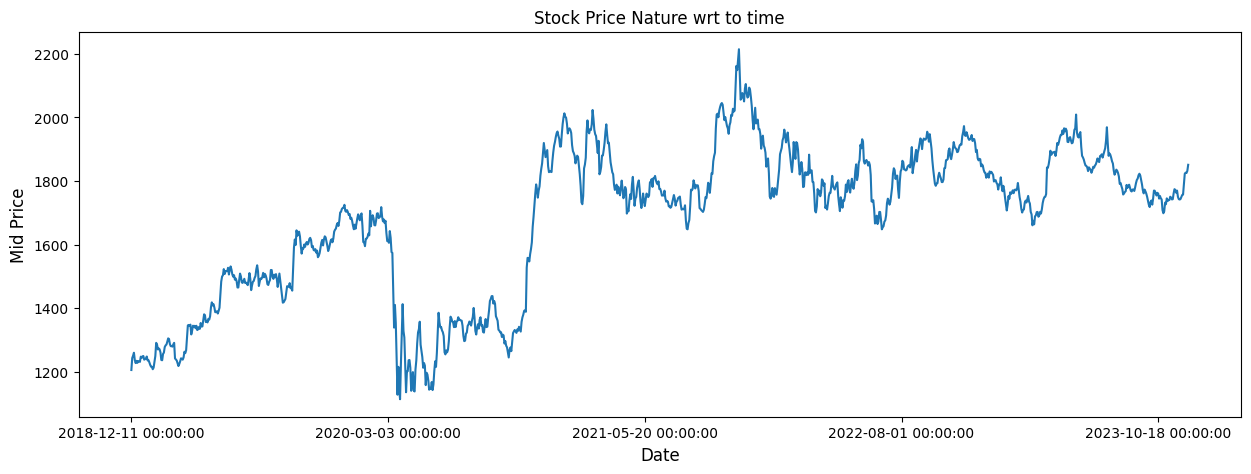

In [7]:
#Visualize the nature of price through out the time period
plt.figure(figsize = (15,5))
plt.plot(range(df.shape[0]),(df['Mid']))
plt.xticks(range(0,df.shape[0],300),df['Date'].loc[::300],rotation=0)
plt.xlabel('Date',fontsize=12)
plt.ylabel('Mid Price',fontsize=12)
plt.title("Stock Price Nature wrt to time")
plt.show()

In [8]:
SEQ_LEN = 60  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "Mid"

In [9]:
def classify(current, future):
    if float(future) > float(current):
        return 1
    else:
        return 0

In [10]:
df['future'] = df[RATIO_TO_PREDICT].shift(-FUTURE_PERIOD_PREDICT)

In [11]:
df['target'] = list(map(classify, df[RATIO_TO_PREDICT], df['future']))

In [12]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Mid,future,target
0,2018-12-11,1189.000000,1239.000000,1171.000000,1218.699951,1215.705444,10078591,1205.000000,1242.599976,1
1,2018-12-12,1229.400024,1261.000000,1224.199951,1237.150024,1234.110107,6563999,1242.599976,1250.200012,1
2,2018-12-13,1240.000000,1271.800049,1228.599976,1264.400024,1261.293091,4227732,1250.200012,1259.399963,1
3,2018-12-14,1264.400024,1271.699951,1247.099976,1255.949951,1252.863770,2671529,1259.399963,1236.525024,0
4,2018-12-17,1260.000000,1266.000000,1207.050049,1222.449951,1219.446045,7385641,1236.525024,1226.825012,0


In [13]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Mid,future,target
1231,2023-12-05,1828.000000,1837.000000,1808.500000,1828.449951,1828.449951,5571472,1822.750000,1826.250000,1
1232,2023-12-06,1832.050049,1839.349976,1813.150024,1821.400024,1821.400024,4695880,1826.250000,1825.125000,0
1233,2023-12-07,1825.000000,1836.849976,1813.400024,1826.849976,1826.849976,2500642,1825.125000,1831.849976,1
1234,2023-12-08,1826.849976,1843.000000,1820.699951,1838.449951,1838.449951,2985466,1831.849976,1850.975037,1
1235,2023-12-11,1845.000000,1861.650024,1840.300049,1844.050049,1844.050049,3204785,1850.975037,NaN,0


In [14]:
times = sorted(df.index.values)  # get the times
last_10pct = sorted(df.index.values)[-int(0.1*len(times))]  # get the last 10% of the times
last_20pct = sorted(df.index.values)[-int(0.2*len(times))]  # get the last 20% of the times

test_df = df[(df.index >= last_10pct)]

train_df = df[(df.index < last_10pct)]  # now the train_df is all the data up to the last 10%

In [15]:
from collections import deque
import numpy as np
import random

In [16]:
train_df

,Date,Open,High,Low,Close,Adj Close,Volume,Mid,future,target
0,2018-12-11,1189.000000,1239.000000,1171.000000,1218.699951,1215.705444,10078591,1205.000000,1242.599976,1
1,2018-12-12,1229.400024,1261.000000,1224.199951,1237.150024,1234.110107,6563999,1242.599976,1250.200012,1
2,2018-12-13,1240.000000,1271.800049,1228.599976,1264.400024,1261.293091,4227732,1250.200012,1259.399963,1
3,2018-12-14,1264.400024,1271.699951,1247.099976,1255.949951,1252.863770,2671529,1259.399963,1236.525024,0
4,2018-12-17,1260.000000,1266.000000,1207.050049,1222.449951,1219.446045,7385641,1236.525024,1226.825012,0
...,...,...,...,...,...,...,...,...,...,...
1108,2023-06-06,1934.900024,1966.400024,1930.150024,1959.050049,1957.438354,4112841,1948.275024,1954.000000,1
1109,2023-06-07,1972.000000,1972.000000,1936.000000,1939.400024,1937.804443,3100414,1954.000000,1908.225037,0
1110,2023-06-08,1936.900024,1936.900024,1879.550049,1886.500000,1884.947876,5491614,1908.225037,1879.199951,0
1111,2023-06-09,1862.000000,1897.699951,1860.699951,1872.000000,1870.459839,14196924,1879.199951,1874.224976,0


In [19]:
train_data = train_df[RATIO_TO_PREDICT].values
train_label = train_df['target'].values

test_data = test_df[RATIO_TO_PREDICT].values
test_label = test_df['target'].values

In [20]:
train_data = train_data.reshape(-1,1)
train_label = train_label.reshape(-1,1)

test_data = test_data.reshape(-1,1)
test_label = test_label.reshape(-1,1)

In [21]:
train_data.shape

(1113, 1)

In [22]:
scaler = MinMaxScaler()

In [23]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 3000
for di in range(0, len(train_data), smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size, :])
    train_data[di:di+smoothing_window_size, :] = scaler.transform(train_data[di:di+smoothing_window_size, :])

# Handling the remaining data after the loop
remaining_data = len(train_data) - (di + smoothing_window_size)
if remaining_data > 0:
    scaler.fit(train_data[di+smoothing_window_size:, :])
    train_data[di+smoothing_window_size:, :] = scaler.transform(train_data[di+smoothing_window_size:, :])

In [24]:
# Reshape both train and test data
train_data = train_data.reshape(-1)
train_label = train_label.reshape(-1)
# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)
test_label = test_label.reshape(-1)

In [25]:
train_label.shape

(1113,)

In [26]:
train_label

array([1, 1, 1, ..., 0, 0, 0])

In [28]:
IMAGE_SIZE = 32  # Image size (32x32)
COLOR_CHANNELS = 3  # Number of color channels

In [29]:
gaf = GramianAngularField(image_size=IMAGE_SIZE, method='d')
gaf = gaf.fit(train_data)

In [30]:
train_images = []
train_labels = []

for i in range(SEQ_LEN, len(train_data)):
    sequence_data = train_data[i - SEQ_LEN:i]
    sequence_data = sequence_data.reshape(1, -1)
    gaf_transformed = gaf.transform(sequence_data)
    resized_gaf = resize(gaf_transformed[0], (IMAGE_SIZE, IMAGE_SIZE))
    resized_gaf_with_channel = np.expand_dims(resized_gaf, axis=-1)
    gaf_image = np.repeat(resized_gaf_with_channel, COLOR_CHANNELS, axis=-1)
    train_images.append(gaf_image)
    train_labels.append(train_label[i + (FUTURE_PERIOD_PREDICT-1)])

train_images = np.array(train_images)
train_labels = np.array(train_labels)
train_labels = np.array(train_labels).reshape(-1, 1)

In [31]:
train_labels.shape

(1053, 1)

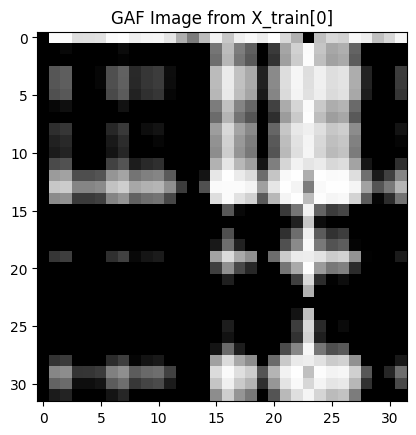

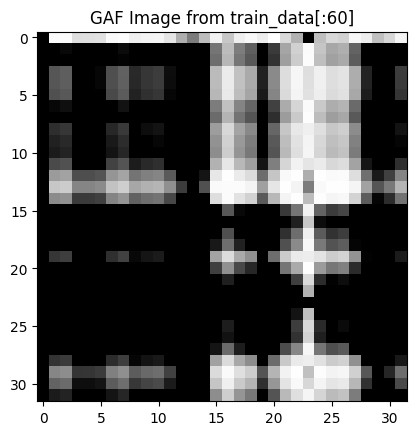

In [32]:
# Verification
sequence_data = train_data[:SEQ_LEN]
sequence_data = sequence_data.reshape(1, -1)
gaf_transformed = gaf.transform(sequence_data)
resized_gaf = resize(gaf_transformed[0], (IMAGE_SIZE, IMAGE_SIZE))
resized_gaf_with_channel = np.expand_dims(resized_gaf, axis=-1)
expected_gaf_image = np.repeat(resized_gaf_with_channel, COLOR_CHANNELS, axis=-1)

plt.imshow(train_images[0])
plt.title('GAF Image from X_train[0]')
plt.show()

plt.imshow(expected_gaf_image)
plt.title('GAF Image from train_data[:60]')
plt.show()

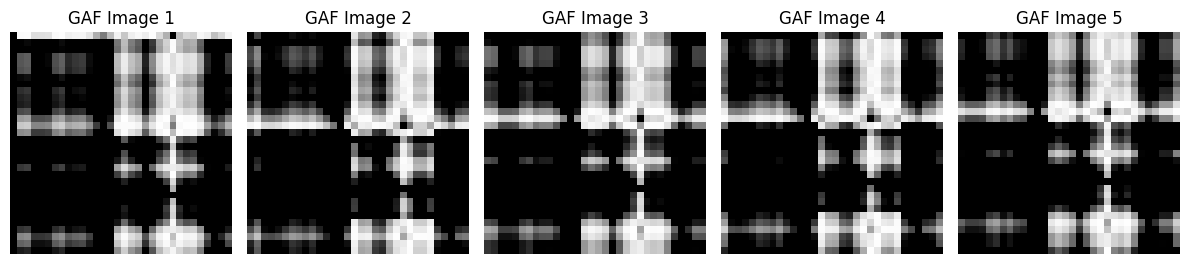

In [33]:
import matplotlib.pyplot as plt

# Visualize the GAF-transformed images
num_images_to_visualize = 5

fig, axes = plt.subplots(1, num_images_to_visualize, figsize=(12, 4))
for i in range(num_images_to_visualize):
    axes[i].imshow(train_images[i], cmap='viridis')
    axes[i].set_title(f'GAF Image {i + 1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [34]:
train_images.shape

(1053, 32, 32, 3)

In [35]:
test_images = []
test_labels = []

for i in range(SEQ_LEN, len(test_data)):
    sequence_data = test_data[i - SEQ_LEN:i]
    sequence_data = sequence_data.reshape(1, -1)
    gaf_transformed = gaf.transform(sequence_data)
    resized_gaf = resize(gaf_transformed[0], (IMAGE_SIZE, IMAGE_SIZE))
    resized_gaf_with_channel = np.expand_dims(resized_gaf, axis=-1)
    gaf_image = np.repeat(resized_gaf_with_channel, COLOR_CHANNELS, axis=-1)
    test_images.append(gaf_image)
    test_labels.append(test_label[i + (FUTURE_PERIOD_PREDICT-1)])

test_images = np.array(test_images)
test_labels = np.array(test_labels)
test_labels = np.array(test_labels).reshape(-1, 1)

In [36]:
print(test_images.shape)
print(test_labels.shape)

(63, 32, 32, 3)
(63, 1)


In [38]:
train_images.shape

(1053, 32, 32, 3)

In [39]:
train_x = tf.data.Dataset.from_tensor_slices(train_images,)
train_y = tf.data.Dataset.from_tensor_slices(train_labels)
train_dataset = tf.data.Dataset.zip((train_x,train_y))
test_x = tf.data.Dataset.from_tensor_slices(test_images)
test_y = tf.data.Dataset.from_tensor_slices(test_labels)
test_dataset = tf.data.Dataset.zip((test_x,test_y))

CNN Classifier

In [40]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model
model = models.Sequential()

# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Flatten layer
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(units = 1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # For integer labels
              metrics=['accuracy'])

# Assuming train_images and train_labels are NumPy arrays
model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
27/27 [==============================] - 12s 22ms/step - loss: 0.9569 - accuracy: 0.4727 - val_loss: 0.6963 - val_accuracy: 0.5024
Epoch 2/10
27/27 [==============================] - 0s 6ms/step - loss: 0.7025 - accuracy: 0.5071 - val_loss: 0.7012 - val_accuracy: 0.4597
Epoch 3/10
27/27 [==============================] - 0s 6ms/step - loss: 0.6922 - accuracy: 0.5701 - val_loss: 0.7060 - val_accuracy: 0.4597
Epoch 4/10
27/27 [==============================] - 0s 6ms/step - loss: 0.6963 - accuracy: 0.5499 - val_loss: 0.7231 - val_accuracy: 0.5213
Epoch 5/10
27/27 [==============================] - 0s 6ms/step - loss: 0.7093 - accuracy: 0.5368 - val_loss: 0.7210 - val_accuracy: 0.4645
Epoch 6/10
27/27 [==============================] - 0s 6ms/step - loss: 0.6948 - accuracy: 0.5214 - val_loss: 0.7147 - val_accuracy: 0.4360
Epoch 7/10
27/27 [==============================] - 0s 6ms/step - loss: 0.6702 - accuracy: 0.5867 - val_loss: 0.7109 - val_accuracy: 0.4597
Epoch 8/10
27/27 [

In [41]:
# Evaluating the model on the test data
test_loss, test_acc = model.evaluate(test_images, test_labels)

# Print the test accuracy
print(f'Test accuracy: {test_acc}')

2/2 [==============================] - 0s 93ms/step - loss: 0.7255 - accuracy: 0.4762
Test accuracy: 0.4761904776096344
